In [1]:
import torch
import torch.nn as nn

import torchvision.models as models
from torchvision import transforms

from matplotlib import pyplot as plt

from tqdm import tqdm

import images
import objectives

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_tensor_type('torch.cuda.FloatTensor' if torch.cuda.is_available() else 'torch.FloatTensor')

c:\Users\gdhim\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_features = models.vgg19(pretrained=True).features.eval()
model_classifier = models.vgg19(pretrained=True).eval()

c:\Users\gdhim\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\gdhim\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
print("\nmodel children :\n")
for name, module in model_classifier.named_children():
    print(name, module.__class__.__name__)

import inspect
print("\ninspect model :\n")
print(inspect.getsource(model_classifier.classifier.forward))


model children :

features Sequential
avgpool AdaptiveAvgPool2d
classifier Sequential

inspect model :

    def forward(self, input):
        for module in self:
            input = module(input)
        return input



In [3]:
def train(model, objective, param, transforms, epochs = 100, lr = 0.01, verbose = True, ultraverbose = False):
    """
    This function trains some parameters to minimize some objective.

    model : the model we are examining through feature visualization

    objective : the objective we are trying to minimize.
                e.g. the mean activation of a neuron, or the mean activation of a channel
                or darker stuff for demonic blend.
    
    param : the parameters we are trying to optimize.
            e.g. an image we want to train.
    
    transforms : a list of transforms to apply to the parameters before feeding them to the model.
                 when training an image this helps for resilience to noise.
                
    epochs : the number of epochs to train for.

    verbose : whether to print the loss over time.
    """

    model.eval()
    param.train()

    if verbose:
        losses = []
    
    parameters = param.parameters()
    opt = torch.optim.Adam(parameters, lr=lr)

    for epoch in tqdm(range(epochs)) if verbose else range(epochs):
        opt.zero_grad()
        loss = objective(model, param, transforms)
        loss.backward()
        opt.step()
        if verbose:
            losses.append(loss.item())

        if epoch / epochs * 10 % 1 == 0 and ultraverbose:
            image = param()
            images.imshow(image)
    
    if verbose:
        fig, ax = plt.subplots()
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.set_title('Loss over time')
        ax.plot(losses)
        plt.show()
    
    return param
    

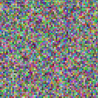

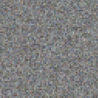

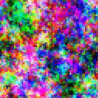

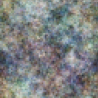

In [24]:
img1 = images.Image(64, std=1, decorrelate=False, fft=False)
img2 = images.Image(64, std=1, decorrelate=True, fft=False)
img3 = images.Image(64, std=1, decorrelate=False, fft=True)
img4 = images.Image(64, std=1, decorrelate=True, fft=True)

images.imshow(img1())
images.imshow(img2())
images.imshow(img3())
images.imshow(img4())

In [4]:
def visualise(objective, model, epochs=500, param = None, image_size=64, lr=10, verbose=True, ultraverbose=False, save=None, show_size=(3, 3), apply_TFORM=True):
    param = images.Image(image_size) if param is None else param
    
    transform1 = images.preprocess_image
    if apply_TFORM:
        transform2 = images.TFORM
        transform = transforms.Compose([transform1, transform2])
    else:
        transform = transform1

    image = train(model, objective, param, transform, epochs=epochs, lr = lr, verbose=verbose, ultraverbose=ultraverbose)
    if save is None:
        images.imshow(image(), size=show_size)
    else:
        images.save_image(image(), save)

## Class Visualisation ##

100%|██████████| 500/500 [00:12<00:00, 40.88it/s]


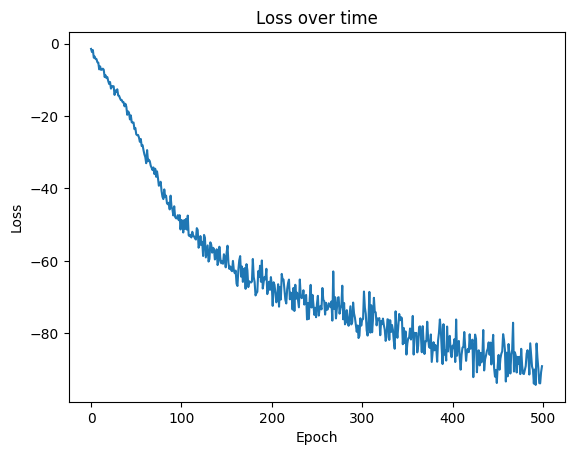

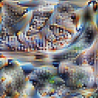

100%|██████████| 500/500 [00:12<00:00, 41.43it/s]


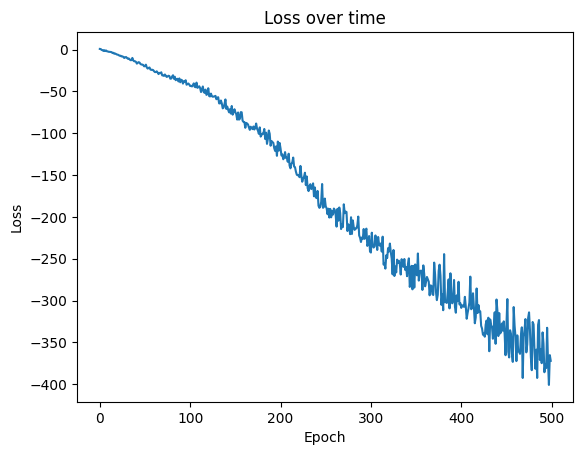

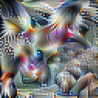

In [26]:
"""
ImageNet classes :

1 : Goldfish
34 : leatherback turtle
269 : gray wolf
296 : polar bear
"""

objective1 = objectives.classe(1)
objective2 = - objectives.classe(1)

visualise(objective1, model=model_classifier)
visualise(objective2, model=model_classifier)

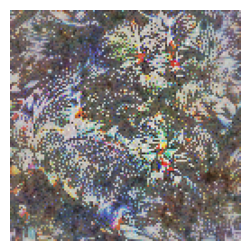

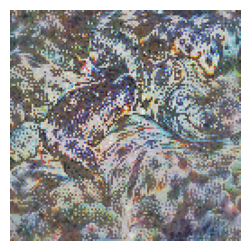

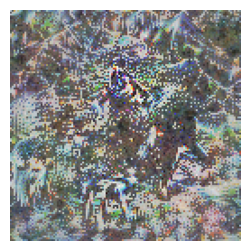

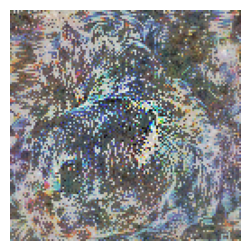

In [24]:
for classe in [1, 34, 269, 296]:
    objective = -objectives.classe(classe)
    visualise(objective, model = model_classifier, image_size=128, epochs=100, lr=100, verbose=False)

We can see hints and somewhat outlines of wolves and polar bear, but that's it...

## Channel Visualisation ##

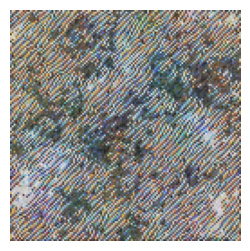

In [6]:
objective = -objectives.channel(model_features, "conv_4", 4)
visualise(objective, model_features, image_size=128, epochs=100, lr=80, verbose=False)

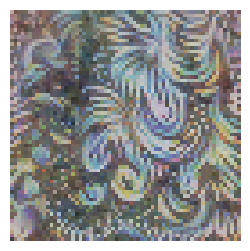

In [12]:
objective = -objectives.channel(model_features, "conv_10", 92)
visualise(objective, model_features, image_size=64, epochs=100, lr=20, verbose=False)

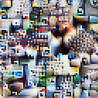

In [43]:
objective = -objectives.channel(model_features, "conv_16", 4)
visualise(objective, model_features, image_size=64, epochs=100, lr=80, verbose=False)

channel 0


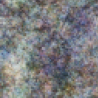

channel 1


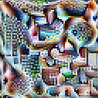

channel 2


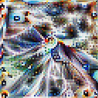

channel 3


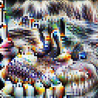

channel 4


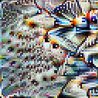

channel 5


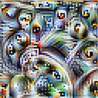

channel 6


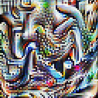

channel 7


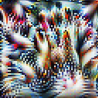

channel 8


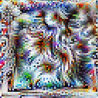

channel 9


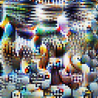

In [45]:
for c in range(10):
    print("channel", c)
    objective = -objectives.channel(model_features, "conv_14", c)
    visualise(objective, model=model_features, image_size=64, epochs=100, lr=80, verbose=False)

channel 0


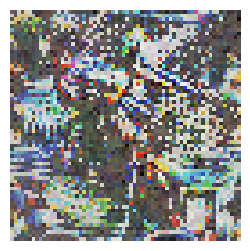

channel 1


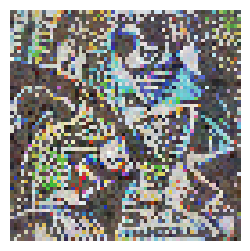

channel 2


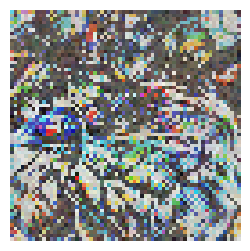

channel 3


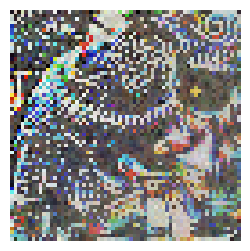

channel 4


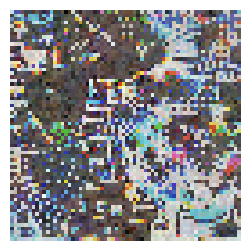

channel 5


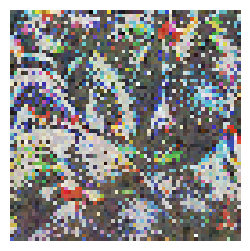

channel 6


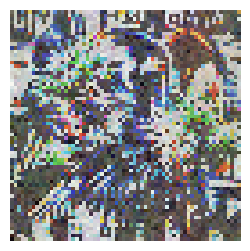

channel 7


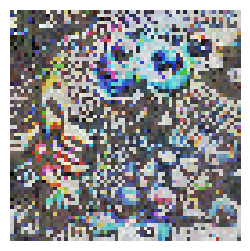

channel 8


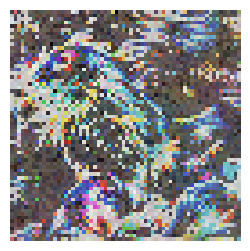

channel 9


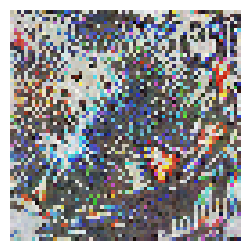

In [26]:
for c in range(10):
    print("channel", c)
    objective = -objectives.channel(model_features, "relu_13", c)
    visualise(objective, model=model_features, image_size=64, epochs=100, lr=80, verbose=False)

## Layer Visualisation ##
###
#### (Deep Dream) ####

Layer :  1


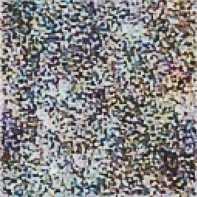

Layer :  2


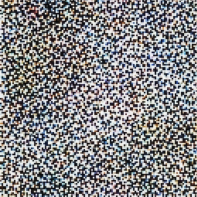

Layer :  3


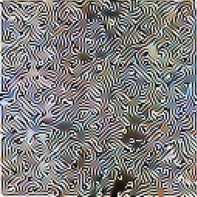

Layer :  4


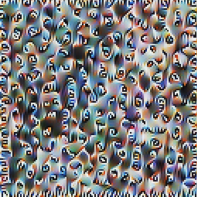

Layer :  5


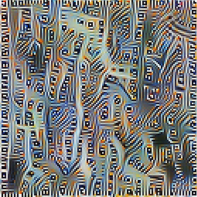

Layer :  6


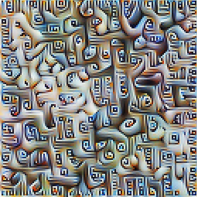

Layer :  7


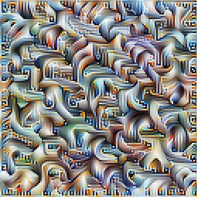

Layer :  8


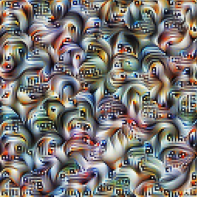

Layer :  9


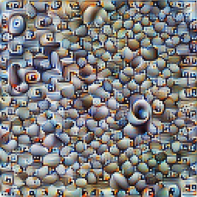

Layer :  10


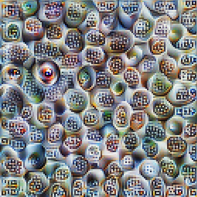

Layer :  11


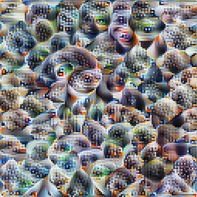

Layer :  12


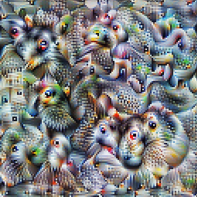

Layer :  13


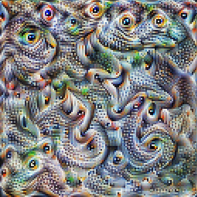

Layer :  14


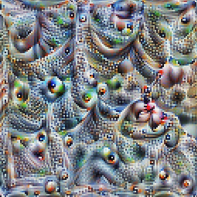

Layer :  15


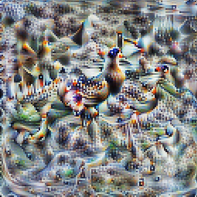

Layer :  16


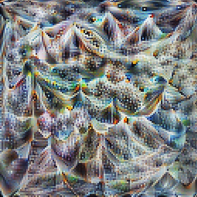

In [52]:
for i in range(1, 17):
    objective = -objectives.layer(model_features, "conv_"+str(i))
    print("Layer : ", i)
    visualise(objective, model_features, image_size=128, epochs=100, lr=80, verbose=False)

## Kindergarten ##

As my images sucks and I don't understand why, I will take existing images and train them.

torch.Size([1, 3, 224, 398])


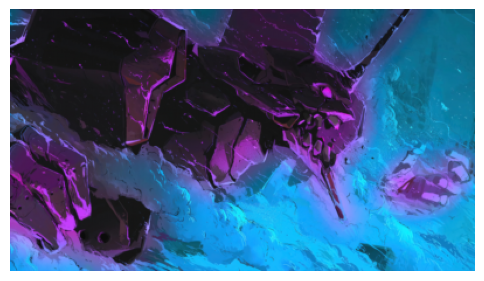

In [12]:
base_img = images.ExistingFourierImage("images/Eva_01.jpg", resize=224)

print(base_img().shape)
images.imshow(base_img())

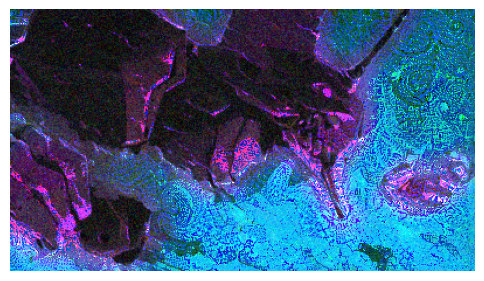

In [26]:
base_img = images.ExistingFourierImage("images/Eva_01.jpg", resize=224)
objective = -objectives.layer(model_features, "conv_13")
visualise(objective, model_features, param=base_img, epochs=10, lr=1e1, verbose=False, show_size=(6, 6))

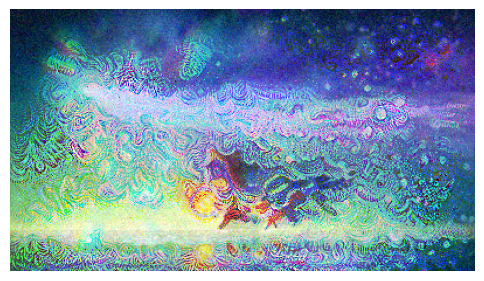

In [27]:
base_img = images.ExistingFourierImage("images/OS.jpg", resize=224)
objective = -objectives.channel(model_features, "conv_10", 92)
visualise(objective, model_features, param=base_img, epochs=10, lr=1e1, verbose=False, show_size=(6, 6))

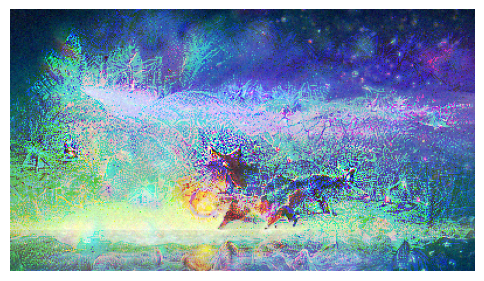

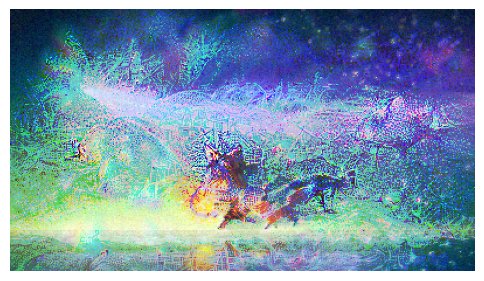

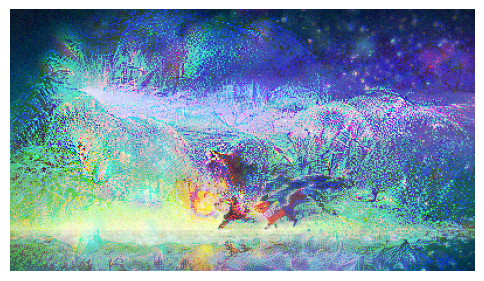

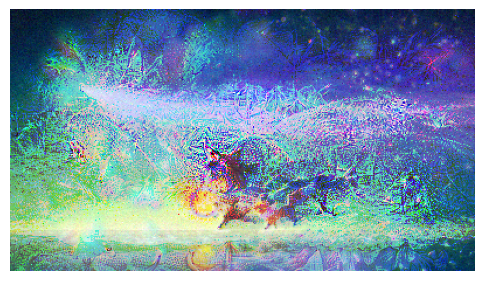

In [31]:
"""
 277: 'red fox, Vulpes vulpes',
 278: 'kit fox, Vulpes macrotis',
 279: 'Arctic fox, white fox, Alopex lagopus',
 280: 'grey fox, gray fox, Urocyon cinereoargenteus',
"""

for i in range(277, 281):
    base_img = images.ExistingFourierImage("images/OS.jpg", resize=224)
    objective = -objectives.classe(i)
    visualise(objective, model_classifier, param=base_img, epochs=50, lr=5e0, verbose=False, show_size=(6, 6))

As you can see, the fox does not becom more foxish ! This is yet again a failure ! Yayyyy

#### Demonic Blend ####

See dedicated notebook for more

In [6]:
base_img_path = 'images/OS.jpg'
style_img_path = 'images/starry_night.jpg'

size = (224, 398)

base_img = images.ExistingImage(base_img_path, resize=size, train=False)().detach()
style_img = images.ExistingImage(style_img_path, resize=size, train=False)().detach()

blend_img = images.ExistingFourierImage(base_img_path, resize=size)

base_layers = [
    'conv_4'
]

style_layers = [
    'conv_1',
    'conv_2',
    'conv_3',
    'conv_4',
    'conv_5'
]

In [6]:
base_obj = objectives.stream_difference(model_features, base_layers, base_img)
style_obj = objectives.stream_difference(model_features, style_layers, style_img, transform=objectives.feature_corelation_matrix)

objective = 0.01 * base_obj + 1e3 * style_obj

100%|██████████| 250/250 [00:05<00:00, 42.87it/s]


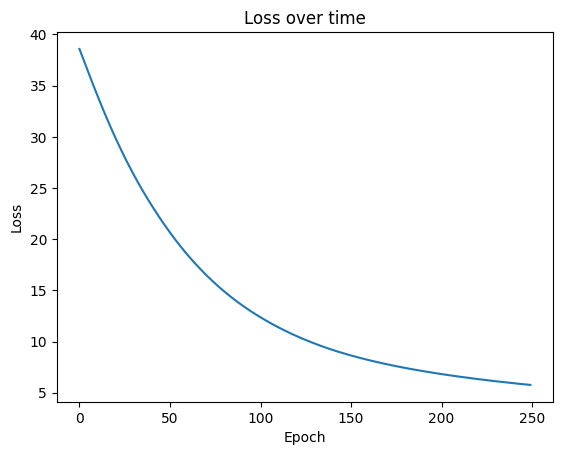

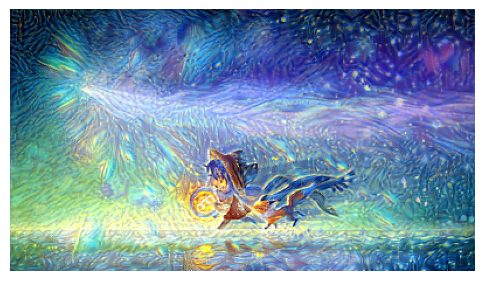

In [7]:
visualise(objective, model_features, param=blend_img, lr=2e-1, epochs=250, apply_TFORM = False, show_size=(6, 6))